In [1]:
from pdpbox import pdp
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd


/Users/ajouad/Desktop/M2DSB/algofairness/Interpretable-jimams/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [3]:
raw_data = pd.read_csv("../data/data_clean.csv")
data = raw_data[raw_data['birth date'] < 2020].copy()

data['age'] = data['parole board interview date'] - data['birth date']
data['jail duration'] = data['parole board interview date'] - data['year of entry']

others_parole_type =  ['PIE', 'SP CONSDR', 'ECPDO', 'MEDICAL','RESCISSION', 'DEPORT']
data['parole board interview type'] = data['parole board interview type'].replace(others_parole_type, 'OTHERS').replace('SUPP MERIT', 'MERIT TIME').replace('PV REAPP', 'REAPPEAR')

data = data.dropna(axis=0, subset=['crime 1 - class', 'parole eligibility date'])

df_one_hot = pd.get_dummies(data, columns=[
    "sex", "race / ethnicity"], drop_first=True)

df_one_hot = pd.get_dummies(df_one_hot, columns=[
    "crime 1 - class", "crime 2 - class",
    "crime 3 - class", "crime 4 - class",
    "parole board interview type"])

df_one_hot.drop(columns=['release date','birth date', 'year of entry'],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_one_hot.drop('y',axis=1), df_one_hot['y'], 
                                                    stratify=df_one_hot['y'], test_size=0.3, random_state=42)

## Loading the model

In [4]:
# Load the model from the .pkl file
xgb_classifier = pickle.load(open("../model.pkl", "rb"))


## PDP

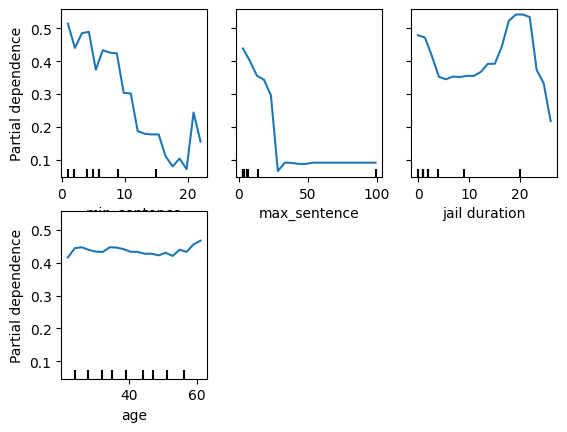

In [25]:
import pandas as pd
import pickle
from sklearn.inspection import PartialDependenceDisplay

# Load the model from the .pkl file
xgb_classifier = pickle.load(open("../model.pkl", "rb"))

# Assuming X_train is your features dataset
features = ['min_sentence', 'max_sentence', 'jail duration', 'age']
feature_names = list(X_train.columns)
# Use PartialDependenceDisplay.from_estimator to create the PDPs
PartialDependenceDisplay.from_estimator(
    xgb_classifier, X_train, features=features,
    feature_names=feature_names,  # Replace with the actual feature names
    grid_resolution=20  # Controls the number of values to plot on the x-axis
)

# To show the plot if not using an interactive environment like Jupyter Notebook
import matplotlib.pyplot as plt
plt.show()


## ALE

[codecarbon INFO @ 19:15:39] [setup] RAM Tracking...
[codecarbon INFO @ 19:15:39] [setup] GPU Tracking...
[codecarbon INFO @ 19:15:39] No GPU found.
[codecarbon INFO @ 19:15:39] [setup] CPU Tracking...
[codecarbon WARNING @ 19:15:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 19:15:39] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 19:15:39] >>> Tracker's metadata:
[codecarbon INFO @ 19:15:39]   Platform system: macOS-13.2.1-arm64-arm-64bit
[codecarbon INFO @ 19:15:39]   Python version: 3.11.6
[codecarbon INFO @ 19:15:39]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 19:15:39]   Available RAM : 8.000 GB
[codecarbon INFO @ 19:15:39]   CPU count: 8
[codecarbon INFO @ 19:15:39]   CPU model: Apple M1
[codecarbon INFO @ 19:15:39]   GPU count: None
[codecarbon INFO @ 19:15:39]   GPU model: None
[codecarbon INFO @ 19:15:45] Energy consumed for RAM : 0.000002 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:15:45] Energy consumed for all

4.046928346137206e-07


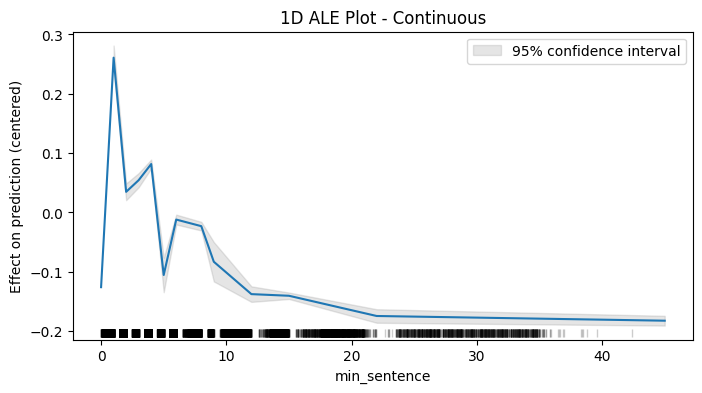

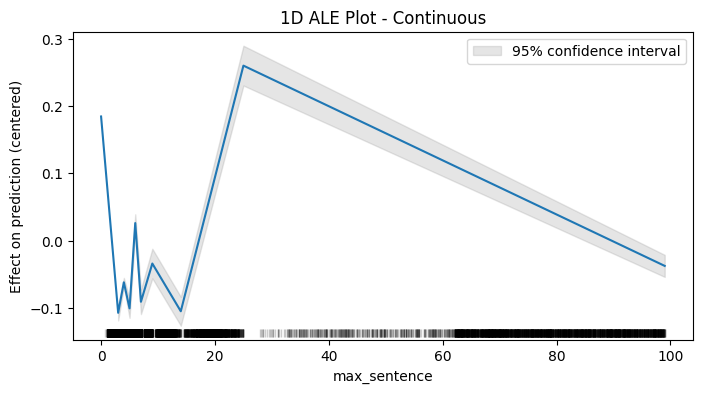

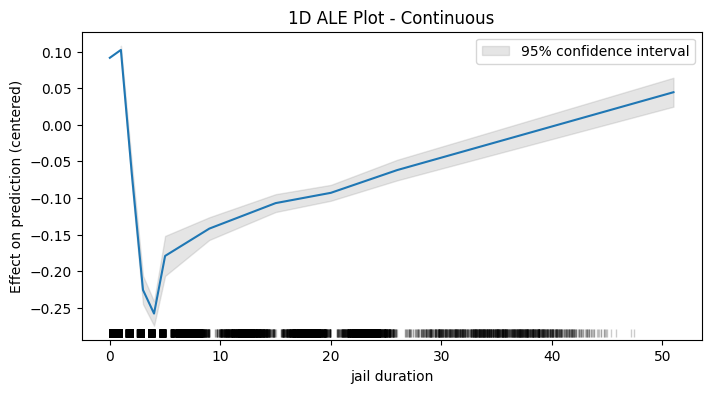

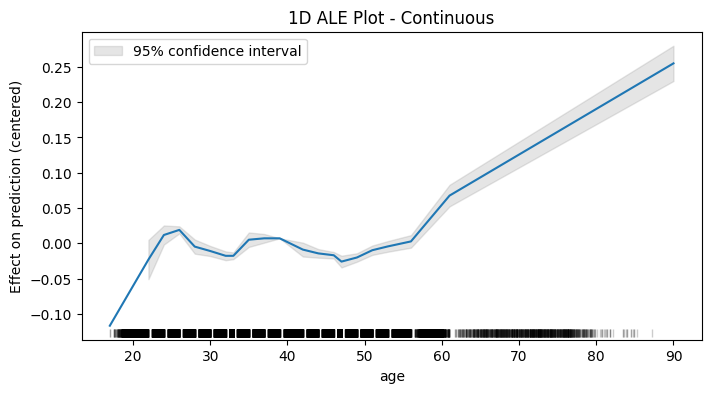

In [51]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker()
tracker.start()

from PyALE import ale

features = ['min_sentence', 'max_sentence', 'jail duration', 'age']
X_sample = X_train[:1000]
for feature in features :
    ale_contin = ale(
        X=X_train,
        model=xgb_classifier,
        feature=[feature],
        feature_type="continuous",
        grid_size=20,
        include_CI=True,
        C=0.95,
    )
    
emissions: float = tracker.stop()
print(emissions)


## ICE

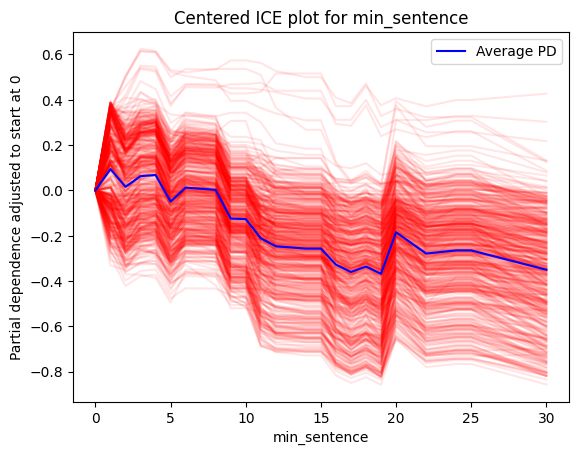

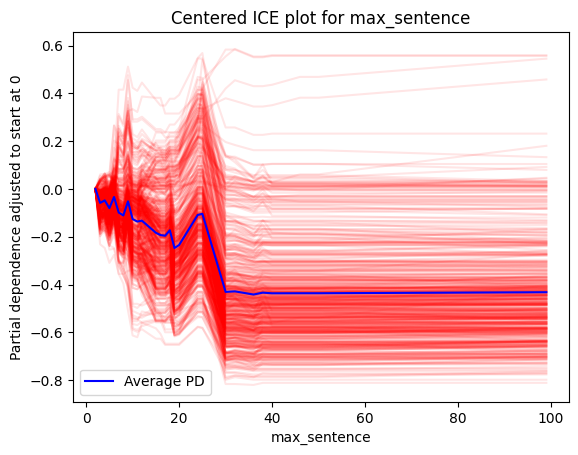

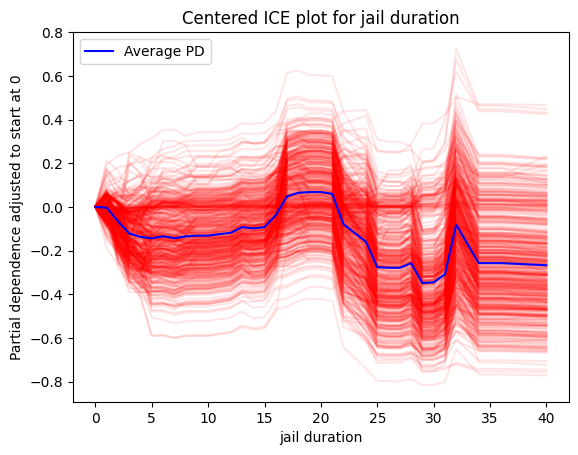

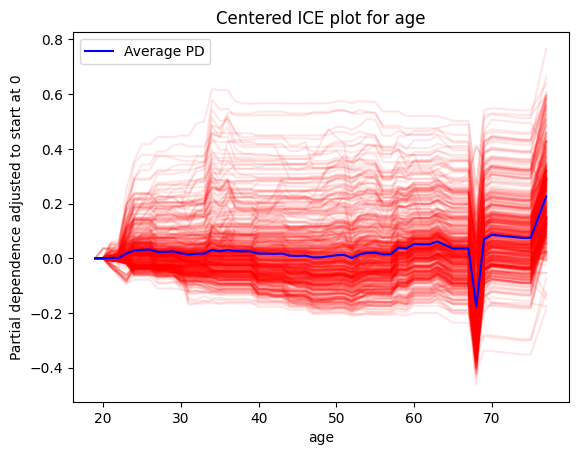

In [35]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

# Load the model from the .pkl file
xgb_classifier = pickle.load(open("../model.pkl", "rb"))

# Assuming X_train is your features dataset
features = ['min_sentence', 'max_sentence', 'jail duration', 'age']
feature_names = list(X_train.columns)

# Plot the centered ICE plots
for feature in features:
    # Calculate the partial dependence values
    pdp_result = partial_dependence(xgb_classifier, X_train.sample(n=500,random_state=42), [feature], kind="both")
    
    # Get the individual and average values
    individual_pd = pdp_result.individual[0]
    average_pd = pdp_result.average[0]
    values = pdp_result.grid_values[0]  # Updated from 'values' to 'grid_values'
    
    # Find the index of the minimum feature value to use as a reference
    reference_index = np.argmin(values)
    
    # Centering the ICE data by subtracting the value of each line at the reference index
    individual_centered = individual_pd - individual_pd[:, reference_index, np.newaxis]
    
    plt.figure()
    for ice_line in individual_centered:
        plt.plot(values, ice_line, color='red', alpha=0.1)
    
    # Center the average partial dependence as well
    average_centered = average_pd - average_pd[reference_index]
    
    plt.plot(values, average_centered, color='blue', label='Average PD')
    
    plt.title(f"Centered ICE plot for {feature}")
    plt.xlabel(feature)
    plt.ylabel('Partial dependence adjusted to start at 0')
    plt.legend()
    plt.show()


## SHAP

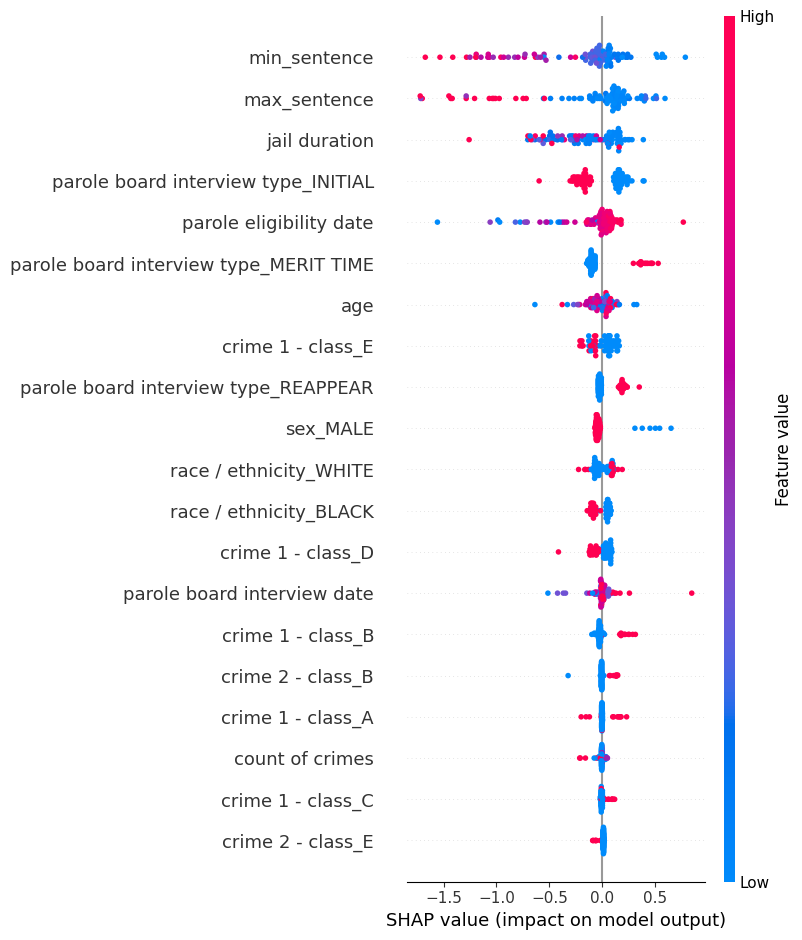

In [5]:
import shap

# Load JS visualization code to notebook
shap.initjs()

# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_classifier)

# Calculate SHAP values - this may take some time depending on the size of your dataset and model complexity
X_train_summary = shap.sample(X_train, 100)  # Use a subset of data as a representative for training data
shap_values = explainer.shap_values(X_train_summary)

# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_summary.iloc[0,:])

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train_summary)
